In [1]:
%cd /kaggle/input/filesdata1/Test_Minist
!ls

/kaggle/input/filesdata1/Test_Minist
configs  models  run.sh  test_imgs  tools  utils


In [2]:
!pip install mmcv-full==1.7.0 -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html
!pip install mmsegmentation
!pip install timm
!pip install datasets
# !pip install comet-ml

Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.7/831.7 kB 12.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.8/648.8 kB 39.3 MB/s eta 0:00:00


In [3]:
import torch 
import albumentations as A

from torch.nn.functional import one_hot
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.utils import make_grid
from torchvision.io import read_image

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import json
import time

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu";
device

'cuda'

In [5]:
print(torch.version.cuda), print(torch.__version__)

11.3
1.13.0


(None, None)

# Getting Model

In [6]:
# for k in dataloaderTest:
#     print(k[3].shape)
#     e1 = k[3]
#     break
# # Auxi 
# from utils.segformer import FCNHead
# auxi_net = FCNHead(num_convs=1,
#                         kernel_size=3,
#                         concat_input=True,
#                         in_channels=320,
#                         num_classes=512,
#                         norm_cfg=dict(type='SyncBN', requires_grad=True))
# auxi_net = auxi_net.to(device)
# auxi_out = auxi_net([a,b,c,d])
# print(f"Auxi Net: {auxi_out.shape}") #torch.Size([2, 64, 64, 64]) torch.Size([2, 128, 32, 32]) torch.Size([2, 320, 16, 16]) torch.Size([2, 512, 8, 8]) outpuy->torch.Size([2, 512, 16, 16])
# #v = a.max(1)[1]
# print("Auxi Output ",auxi_out.shape)

# ll = np.load('/kaggle/input/mlxardata1/Test_Minist/models/universal_cat2vec.npy', mmap_mode='r')
# print("npy shape: ",ll.shape)
# embeddInput = torch.tensor(ll,device=device)

# embedd = torch.nn.Embedding(num_embeddings=ll.shape[0], embedding_dim=ll.shape[1], _weight = embeddInput)
# e1 = e1.float()
# e1 = torch.permute(e1,(0,3,1,2))
# print(f"e1 shape {e1.shape}")
# e1 = torch.nn.functional.interpolate(e1, size=(16,16), mode='bilinear', align_corners=True)
# print(f"After Resze e1 shape {e1.shape}")

# predictedLabelsIndex = torch.argmax(e1, dim=1)
# print(e1.shape, predictedLabelsIndex.shape)
 
# outEmbed = embedd(predictedLabelsIndex.to(device))
# outEmbed.shape

In [7]:
# Mertic Class 
class Metric(object):
    """Base class for all metrics.

    From: https://github.com/pytorch/tnt/blob/master/torchnet/meter/meter.py
    """
    def reset(self):
        pass

    def add(self):
        pass

    def value(self):
        pass
class ConfusionMatrix(Metric):
    """Constructs a confusion matrix for a multi-class classification problems.

    Does not support multi-label, multi-class problems.

    Keyword arguments:
    - num_classes (int): number of classes in the classification problem.
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.

    Modified from: https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
    """

    def __init__(self, num_classes, normalized=False):
        super().__init__()

        self.conf = np.ndarray((num_classes, num_classes), dtype=np.int64)
        self.normalized = normalized
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        self.conf.fill(0)

    def add(self, predicted, target):
        """Computes the confusion matrix

        The shape of the confusion matrix is K x K, where K is the number
        of classes.

        Keyword arguments:
        - predicted (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        predicted scores obtained from the model for N examples and K classes,
        or an N-tensor/array of integer values between 0 and K-1.
        - target (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        ground-truth classes for N examples and K classes, or an N-tensor/array
        of integer values between 0 and K-1.

        """
        # If target and/or predicted are tensors, convert them to numpy arrays
        if torch.is_tensor(predicted):
            predicted = predicted.cpu().numpy()
        if torch.is_tensor(target):
            target = target.cpu().numpy()

        assert predicted.shape[0] == target.shape[0], \
            'number of targets and predicted outputs do not match'

        if np.ndim(predicted) != 1:
            assert predicted.shape[1] == self.num_classes, \
                'number of predictions does not match size of confusion matrix'
            predicted = np.argmax(predicted, 1)
        else:
            assert (predicted.max() < self.num_classes) and (predicted.min() >= 0), \
                'predicted values are not between 0 and k-1'

        if np.ndim(target) != 1:
            assert target.shape[1] == self.num_classes, \
                'Onehot target does not match size of confusion matrix'
            assert (target >= 0).all() and (target <= 1).all(), \
                'in one-hot encoding, target values should be 0 or 1'
            assert (target.sum(1) == 1).all(), \
                'multi-label setting is not supported'
            target = np.argmax(target, 1)
        else:
            assert (target.max() < self.num_classes) and (target.min() >= 0), \
                'target values are not between 0 and k-1'

        # hack for bincounting 2 arrays together
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(
            x.astype(np.int64), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        self.conf += conf

    def value(self):
        """
        Returns:
            Confustion matrix of K rows and K columns, where rows corresponds
            to ground-truth targets and columns corresponds to predicted
            targets.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        else:
            return self.conf
class IoU(Metric):
    """Computes the intersection over union (IoU) per class and corresponding
    mean (mIoU).

    Intersection over union (IoU) is a common evaluation metric for semantic
    segmentation. The predictions are first accumulated in a confusion matrix
    and the IoU is computed from it as follows:

        IoU = true_positive / (true_positive + false_positive + false_negative).

    Keyword arguments:
    - num_classes (int): number of classes in the classification problem
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.
    - ignore_index (int or iterable, optional): Index of the classes to ignore
    when computing the IoU. Can be an int, or any iterable of ints.
    """

    def __init__(self, num_classes, normalized=False, ignore_index=None):
        super().__init__()
        self.conf_metric = ConfusionMatrix(num_classes, normalized)

        if ignore_index is None:
            self.ignore_index = None
        elif isinstance(ignore_index, int):
            self.ignore_index = (ignore_index,)
        else:
            try:
                self.ignore_index = tuple(ignore_index)
            except TypeError:
                raise ValueError("'ignore_index' must be an int or iterable")

    def reset(self):
        self.conf_metric.reset()

    def add(self, predicted, target):
        """Adds the predicted and target pair to the IoU metric.

        Keyword arguments:
        - predicted (Tensor): Can be a (N, K, H, W) tensor of
        predicted scores obtained from the model for N examples and K classes,
        or (N, H, W) tensor of integer values between 0 and K-1.
        - target (Tensor): Can be a (N, K, H, W) tensor of
        target scores for N examples and K classes, or (N, H, W) tensor of
        integer values between 0 and K-1.

        """
        # Dimensions check
        assert predicted.size(0) == target.size(0), \
            'number of targets and predicted outputs do not match'
        assert predicted.dim() == 3 or predicted.dim() == 4, \
            "predictions must be of dimension (N, H, W) or (N, K, H, W)"
        assert target.dim() == 3 or target.dim() == 4, \
            "targets must be of dimension (N, H, W) or (N, K, H, W)"

        # If the tensor is in categorical format convert it to integer format
        if predicted.dim() == 4:
            _, predicted = predicted.max(1)
        if target.dim() == 4:
            _, target = target.max(1)

        self.conf_metric.add(predicted.view(-1), target.view(-1))

    def value(self):
        """Computes the IoU and mean IoU.

        The mean computation ignores NaN elements of the IoU array.

        Returns:
            Tuple: (IoU, mIoU). The first output is the per class IoU,
            for K classes it's numpy.ndarray with K elements. The second output,
            is the mean IoU.
        """
        conf_matrix = self.conf_metric.value()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)

        return iou, np.nanmean(iou)
class DiceAndPixelAcc(object):
    r"""Calculate common metrics in semantic segmentation to evalueate model preformance.
    Supported metrics: Pixel accuracy, Dice Coeff, precision score and recall score.
    
    Pixel accuracy measures how many pixels in a image are predicted correctly.
    Dice Coeff is a measure function to measure similarity over 2 sets, which is usually used to
    calculate the similarity of two samples. Dice equals to f1 score in semantic segmentation tasks.
    
    It should be noted that Dice Coeff and Intersection over Union are highly related, so you need 
    NOT calculate these metrics both, the other can be calcultaed directly when knowing one of them.
    Precision describes the purity of our positive detections relative to the ground truth. Of all
    the objects that we predicted in a given image, precision score describes how many of those objects
    actually had a matching ground truth annotation.
    Recall describes the completeness of our positive predictions relative to the ground truth. Of
    all the objected annotated in our ground truth, recall score describes how many true positive instances
    we have captured in semantic segmentation.
    Args:
        eps: float, a value added to the denominator for numerical stability.
            Default: 1e-5
        average: bool. Default: ``True``
            When set to ``True``, average Dice Coeff, precision and recall are
            returned. Otherwise Dice Coeff, precision and recall of each class
            will be returned as a numpy array.
        ignore_background: bool. Default: ``True``
            When set to ``True``, the class will not calculate related metrics on
            background pixels. When the segmentation of background pixels is not
            important, set this value to ``True``.
        activation: [None, 'none', 'softmax' (default), 'sigmoid', '0-1']
            This parameter determines what kind of activation function that will be
            applied on model output.
    Input:
        y_true: :math:`(N, H, W)`, torch tensor, where we use int value between (0, num_class - 1)
        to denote every class, where ``0`` denotes background class.
        y_pred: :math:`(N, C, H, W)`, torch tensor.
    Examples::
        >>> metric_calculator = SegmentationMetrics(average=True, ignore_background=True)
        >>> pixel_accuracy, dice, precision, recall = metric_calculator(y_true, y_pred)
    """
    def __init__(self, eps=1e-5, average=True, ignore_background=True, activation='0-1'):
        self.eps = eps
        self.average = average
        self.ignore = ignore_background
        self.activation = activation

    @staticmethod
    def _one_hot(gt, pred, class_num):
        # transform sparse mask into one-hot mask
        # shape: (B, H, W) -> (B, C, H, W)
        input_shape = tuple(gt.shape)  # (N, H, W, ...)
        new_shape = (input_shape[0], class_num) + input_shape[1:]
        one_hot = torch.zeros(new_shape).to(pred.device, dtype=torch.float)
        target = one_hot.scatter_(1, gt.unsqueeze(1).long().data, 1.0)
        return target

    @staticmethod
    def _get_class_data(gt_onehot, pred, class_num):
        # perform calculation on a batch
        # for precise result in a single image, plz set batch size to 1
        matrix = np.zeros((3, class_num))

        # calculate tp, fp, fn per class
        for i in range(class_num):
            # pred shape: (N, H, W)
            class_pred = pred[:, i, :, :]
            # gt shape: (N, H, W), binary array where 0 denotes negative and 1 denotes positive
            class_gt = gt_onehot[:, i, :, :]

            pred_flat = class_pred.contiguous().view(-1, )  # shape: (N * H * W, )
            gt_flat = class_gt.contiguous().view(-1, )  # shape: (N * H * W, )

            tp = torch.sum(gt_flat * pred_flat)
            fp = torch.sum(pred_flat) - tp
            fn = torch.sum(gt_flat) - tp

            matrix[:, i] = tp.item(), fp.item(), fn.item()

        return matrix

    def _calculate_multi_metrics(self, gt, pred, class_num):
        # calculate metrics in multi-class segmentation
        matrix = self._get_class_data(gt, pred, class_num)
        if self.ignore:
            matrix = matrix[:, 1:]

        # tp = np.sum(matrix[0, :])
        # fp = np.sum(matrix[1, :])
        # fn = np.sum(matrix[2, :])

        pixel_acc = (np.sum(matrix[0, :]) + self.eps) / (np.sum(matrix[0, :]) + np.sum(matrix[1, :]))
        dice = (2 * matrix[0] + self.eps) / (2 * matrix[0] + matrix[1] + matrix[2] + self.eps)
        precision = (matrix[0] + self.eps) / (matrix[0] + matrix[1] + self.eps)
        recall = (matrix[0] + self.eps) / (matrix[0] + matrix[2] + self.eps)

        if self.average:
            dice = np.average(dice)
            precision = np.average(precision)
            recall = np.average(recall)

        return pixel_acc, dice, precision, recall

    def __call__(self, y_true, y_pred):
        class_num = y_pred.size(1)

        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "softmax":
            activation_fn = nn.Softmax(dim=1)
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            pred_argmax = torch.argmax(y_pred, dim=1)
            activated_pred = self._one_hot(pred_argmax, y_pred, class_num)
        else:
            raise NotImplementedError("Not a supported activation!")

        gt_onehot = self._one_hot(y_true, y_pred, class_num)
        pixel_acc, dice, precision, recall = self._calculate_multi_metrics(gt_onehot, activated_pred, class_num)
        return pixel_acc, dice, precision, recall

In [8]:
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import os

from PIL import Image
import cv2

from datasets import Dataset as dt
from datasets import load_metric

from datasets import DatasetDict
#metric = load_metric("mean_iou")

# Dataloader Class

In [9]:
def check(a, b):
  firstTerm, seconTerm, thirdTerm = b[0], b[1], b[2]

  for index, i in enumerate(a):
    if(i[0]==firstTerm and i[1]==seconTerm and i[2]==thirdTerm):
      return index
  return False

In [10]:
uniqueColors = [
[  0,   0,   0],
[  0,   0, 170],
[  0,   0, 255],
[  0,  85, 255],
[  0, 170, 255],
[  0, 255, 255],
[ 85, 255, 170],
[170,   0,   0],
[170, 255,  85],
[255,   0,   0],
[255,  85,   0],
[255, 170,   0],
[255, 255,   0]
]
SizeToCrop = 256

In [11]:
class CMPDataset(torch.utils.data.Dataset):
    id2label = {
        0: "unknown",
        1: "background",
        2: "facade", 
        3: "window", 
        4: "door", 
        5: "cornice", 
        6: "sill", 
        7: "balcony", 
        8: "blind",  
        9: "pillar",
        10: "deco", 
        11: "molding",
        12: "shop"
    }
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_paths = []
        self.lbl_paths = []
        self.label2id = {lbl: id for id, lbl in self.id2label.items()}

        # Iterate over the files in the root directory
        for file in sorted(os.listdir(root_dir)):
            # Check if the file is a JPG image
            if file.endswith(".jpg"):
                self.img_paths.append(os.path.join(root_dir, file))
            # Check if the file is an XML file
            elif file.endswith(".png"):
                self.lbl_paths.append(os.path.join(root_dir, file))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        num_labels = 13
        img_path = self.img_paths[idx]
        lbl_path = self.lbl_paths[idx]
        
        #Reading Image and changing to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        originalImage = img
        originalImage = cv2.resize(originalImage, (SizeToCrop,SizeToCrop))
        
        #Reading Mask and changing to RGB
        maskcv2 = cv2.imread(lbl_path)
        maskcv2 = cv2.cvtColor(maskcv2, cv2.COLOR_BGR2RGB)
        originalMask = maskcv2
        originalMask = cv2.resize(originalMask, (SizeToCrop,SizeToCrop))

        # Transformation Before Masklabelling and OneHotEncoded.
        if self.transform:
            transformed = self.transform(image=img, mask=maskcv2)
            img = transformed["image"]
            maskcv2 = transformed["mask"]

        w, h, c = maskcv2.shape
        labelMask = np.zeros((w,h),dtype=int)
        for i in range(0,maskcv2.shape[0]):
            for j in range(0,maskcv2.shape[1]):
                res = check(uniqueColors ,maskcv2[i, j, :])
                if res:
                    labelMask[i][j] = res

        OneHotEncoded = one_hot(torch.tensor(labelMask), num_labels)
        return img, labelMask, OneHotEncoded, maskcv2, originalImage, originalMask

In [12]:
# dataTrain = CMPDataset("/kaggle/input/datasetmlxar/CMP_facade_DB_base/base")
# dataTest = CMPDataset("/kaggle/input/datasetmlxar/CMP_facade_DB_base/test")
train_transform = A.Compose(
    [
        A.Resize(SizeToCrop, SizeToCrop),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.3, p=0.5),
        A.RandomRotate90(p=0.4),
        A.Transpose(p=0.5), # Change x-axis to y and Y-axis to X.
        A.AdvancedBlur(blur_limit=(3, 7), p=0.5)
    ]
)
dataTrain = CMPDataset("/kaggle/input/datasetmlxar/CMP_facade_DB_base/base", transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(SizeToCrop, SizeToCrop)]
)
dataTest = CMPDataset("/kaggle/input/datasetmlxar/CMP_facade_DB_base/test", transform=val_transform,)



In [13]:
dataTrain.__len__(), dataTest.__len__()

(542, 64)

# Dataloader

In [14]:
dataloaderTrain = DataLoader(dataTrain, batch_size=4, shuffle=True)
dataloaderTest = DataLoader(dataTest, batch_size=4, shuffle=True)

In [15]:
# for a in dataloaderTest:
#     print(a[0].shape, a[1].shape, a[3].shape)
#     e1 = a[3]
#     break

# Training Loop 

In [16]:
from utils.segformer import SegFormer

# SegFormer Head
from utils.decode_heads import SegFormerHead

# Auxi 
from utils.segformer import FCNHead

/opt/conda/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


In [17]:
dist_url = 'tcp://127.0.0.1:6769'
dist_url = dist_url[:-2] + str(os.getpid() % 100).zfill(2)

num_gpus = torch.cuda.device_count()
torch.distributed.init_process_group(backend="nccl", init_method=dist_url, world_size=num_gpus, rank=0)

In [18]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__();

    self.encoder = SegFormer("/kaggle/input/filesdata1/Test_Minist/models/custom_new_name_2.pth")

    self.decoder = SegFormerHead(num_classes=13,
                          in_channels=[64, 128, 320, 512],
                          channels=128,
                          in_index=[0,1,2,3],
                          feature_strides=[4, 8, 16, 32],
                          #decoder_params=dict(embed_dim=768),
                          dropout_ratio=0.1,
                          norm_cfg=dict(type='SyncBN', requires_grad=True),
                          align_corners=False)
    

    self.auxiNet = auxi_net = FCNHead(num_convs=1,
                        kernel_size=3,
                        concat_input=True,
                        in_channels=320,
                        num_classes=512, # 512 Embediing Size
                        norm_cfg=dict(type='SyncBN', requires_grad=True))
    #self.sig = torch.nn.Softmax(dim=1)
    
  def forward(self, x):

    w, h = x.shape[3], x.shape[2]
    outEncoder = self.encoder(x)
    outDecoder = self.decoder(outEncoder)
    high_out = torch.nn.functional.interpolate(outDecoder, size=(h,w), mode='bilinear', align_corners=True)
    #high_out = self.sig(high_out)
    
    # Auxi Net
    auxiOutput = self.auxiNet(outEncoder) # Input -> (torch.Size([2, 64, 64, 64]) torch.Size([2, 128, 32, 32]) torch.Size([2, 320, 16, 16]) torch.Size([2, 512, 8, 8])) 
    # auxiOutput output->torch.Size([2, 512, 16, 16])
    
    return high_out, auxiOutput

In [19]:
model = MyModel()
model = model.to(device)
#outs = model(torch.randn(2,3,256,256).to(device))
#outs[0].shape, outs[0][0], outs[0][0].shape

2023-03-25 14:09:51,498 - mmseg - INFO - load checkpoint from local path: /kaggle/input/filesdata1/Test_Minist/models/custom_new_name_2.pth


In [20]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__();
        self.lossCross = torch.nn.CrossEntropyLoss()
        self.lossL1 = torch.nn.L1Loss()
    
    def forward(self,outputsModel, Groundlabel, y_pred, y_truth):
        l1 = self.lossL1(y_pred, y_truth)
        l2 = self.lossCross(outputsModel, Groundlabel)
        TotalLoss = l1 + l2
        return TotalLoss

In [21]:
groundEmbeddings = np.load('/kaggle/input/filesdata1/Test_Minist/models/universal_cat2vec.npy', mmap_mode='r')
embeddInput = torch.tensor(groundEmbeddings, device=device)

embedd = torch.nn.Embedding(num_embeddings=groundEmbeddings.shape[0], embedding_dim=groundEmbeddings.shape[1], _weight = embeddInput)

def preprocessForEmbedding(mask):
    mask = mask.float()
    mask = torch.permute(mask,(0,3,1,2))
    maskResize = nn.functional.interpolate(mask, size=(16,16), mode='bilinear', align_corners=True)
    
    # argmax before converting to ClassIndex
    predictedLabelsIndex = torch.argmax(maskResize, dim=1)
    predictedLabelsIndex = predictedLabelsIndex.to(device)
    groundEmbedded = embedd(predictedLabelsIndex)
    groundEmbedded = torch.permute(groundEmbedded, (0,3,1,2))
    return groundEmbedded # Output -> torch.Size([B, 512, 16, 16])

In [22]:
epochs = 40
modelLoss = CustomLoss()
optim = torch.optim.Adam(model.parameters())

lossTrainPerEpoch = []
lossTestPerEpoch = []
meanIOUPerEpoch = []
pixelAccPerEpoch = []
diceCoffPerEpoch = []

In [23]:
# Metrics initialisation from metrics.py
#from metrics import DiceAndPixelAcc, IoU

In [24]:
instIOU = IoU(13)
instDicePixel = DiceAndPixelAcc(average=True)

In [25]:
%cd /kaggle/working/

/kaggle/working


In [26]:
def IndexesToImage(img, uniqueColors):
    innerList = []
    imgList = []
    for batchNumber, imgIndex in enumerate(img):
        h,w = imgIndex.shape[1], imgIndex.shape[0]
        innerList = []
        for i in range(0,h):
            for j in range(0,w):
                innerList.append(uniqueColors[imgIndex[i][j]])
        innerToNumpy = np.array(innerList).reshape(w,h,-1)
        innerToNumpy = np.expand_dims(innerToNumpy, axis=0)
        innerToTorch = torch.from_numpy(innerToNumpy)
        imgList.append(innerToTorch)
    
    batchofTensors = torch.concat(imgList, axis=0)
    return batchofTensors

In [27]:
# for indx,(img, groundLabel, OneHotEncodedLabel, mask) in enumerate(dataloaderTrain):
#     print(img.shape, groundLabel.shape, OneHotEncodedLabel.shape, mask.shape)
#     break
# #torch.Size([4, 256, 256, 3]) torch.Size([4, 256, 256]) torch.Size([4, 256, 256, 13]) torch.Size([4, 256, 256, 3])

In [28]:
for epoch in range(0,epochs):
    print(f"==================================================Epoch no: {epoch}========================================================")
    start_time = datetime.now()
    lossTrain = 0
    lossTest = 0
    iou = 0
    piAcc = 0
    diCoff = 0
    for indx,(img, groundLabel, OneHotEncodedLabel, mask,originalImage, originalMask) in enumerate(dataloaderTrain):

        img = torch.tensor(img, device=device, dtype=torch.float32)
        img = torch.permute(img, (0,3,1,2))
        OneHotEncodedLabel = OneHotEncodedLabel.to(device)
        OneHotEncodedLabel = OneHotEncodedLabel.type(torch.float32)
        OneHotEncodedLabel = torch.permute(OneHotEncodedLabel, (0,3,1,2))
        OneHotEncodedLabelArgmax = torch.argmax(OneHotEncodedLabel, dim=1)
        #OneHotEncodedLabelArgmax = torch.unsqueeze(OneHotEncodedLabelArgmax,1)
        
        outputsModel = model(img)
        trainingLabelsIndex = torch.argmax(outputsModel[0], dim=1)
        optim.zero_grad()

        postmasking = preprocessForEmbedding(mask)
        loss = modelLoss(outputsModel[0], OneHotEncodedLabelArgmax, outputsModel[1], postmasking)
        lossTrain+=loss.item()
        loss.backward()
        optim.step()
        
    lossTrainPerEpoch.append(lossTrain/(indx+1))
    print(f"Average Training Loss after Epoch Number {epoch} : {lossTrain/(indx+1)}")
    
    # Model Evaluation
    for indx,(img, groundLabel, OneHotEncodedLabel, mask, originalImageTest, originalMaskTest) in enumerate(dataloaderTest):
        model.eval()

        with torch.no_grad():
            img = torch.tensor(img, device=device, dtype=torch.float32)
            img = torch.permute(img, (0,3,1,2))
            OneHotEncodedLabel = OneHotEncodedLabel.to(device)
            OneHotEncodedLabel = OneHotEncodedLabel.type(torch.float32)
            OneHotEncodedLabel = torch.permute(OneHotEncodedLabel, (0,3,1,2))
            OneHotEncodedLabelArgmax = torch.argmax(OneHotEncodedLabel, dim=1)
            
            testOutputs = model(img)
            testingLabelsIndex = torch.argmax(testOutputs[0], dim=1)

            # Model Loss
            processMasking = preprocessForEmbedding(mask)
            evalLoss = modelLoss(testOutputs[0], OneHotEncodedLabelArgmax, testOutputs[1], processMasking)
            lossTest += evalLoss.item()

            predictedLabelsIndex = torch.argmax(testOutputs[0], dim=1)

            # Calculating Pixel Accuracy and Dice Coefficent
            pixelAcc, diceCoff,_, _ = instDicePixel( groundLabel.to(device), testOutputs[0].to(device)) 
            instIOU.add(predictedLabelsIndex, groundLabel)
            _, meanIOU = instIOU.value()
            iou+=meanIOU
            piAcc+=pixelAcc
            diCoff+=diceCoff
            
    print(f"Average Test Loss after Epoch Number {epoch} : {lossTest/(indx+1)}")
    print(f"Pixel Accuracy after Epoch Number {epoch} : {piAcc/(indx+1)}")
    print(f"Dice Coff after Epoch Number {epoch} : {diCoff/(indx+1)}")

    meanIOUPerEpoch.append(iou/len(dataloaderTest))
    lossTestPerEpoch.append(lossTest/len(dataloaderTest))
    pixelAccPerEpoch.append(piAcc/len(dataloaderTest))
    diceCoffPerEpoch.append(diceCoff/len(dataloaderTest))

    # Converting predictedLabelsIndex to RGB for Visualisation purpose
    predictedLabels = IndexesToImage(predictedLabelsIndex, uniqueColors) # output -> Torch Tensor (B,3,256,256)

    mask = torch.permute(mask,(0,3,1,2))
    # Visualising Last Epoch: Images || Predicted Label || Groundlabel
    mask = mask.to(device)
    predictedLabels = predictedLabels.to(device)
    predictedLabels = torch.permute(predictedLabels, (0,3,1,2))  

    if epoch%7 == 0:
        PATH = f'/kaggle/working/demo_model_Epoch{epoch}.pt'
        torch.save(model.state_dict(), PATH)
    end_time = datetime.now()
    time_difference = (end_time - start_time).total_seconds() * 10**3
    print(f"Execution time of epoch {epoch} no : ", time_difference, "ms")
    print("==========================================================================================================")

==================================================Epoch no: 0========================================================


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Average Training Loss after Epoch Number 0 : 1.4731360954396866


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Average Test Loss after Epoch Number 0 : 1.3640290424227715
Pixel Accuracy after Epoch Number 0 : 0.5438618660354615
Dice Coff after Epoch Number 0 : 0.2872315835560883
Execution time of epoch 0 no :  681484.1780000001 ms
==================================================Epoch no: 1========================================================
Average Training Loss after Epoch Number 1 : 1.292048708480947
Average Test Loss after Epoch Number 1 : 1.2144249752163887
Pixel Accuracy after Epoch Number 1 : 0.5789122581863404
Dice Coff after Epoch Number 1 : 0.32908887553512406
Execution time of epoch 1 no :  659423.633 ms
==================================================Epoch no: 2========================================================
Average Training Loss after Epoch Number 2 : 1.1929832749507006
Average Test Loss after Epoch Number 2 : 1.3550626337528229
Pixel Accuracy after Epoch Number 2 : 0.5460698604965211
Dice Coff after Epoch Number 2 : 0.2587978913408566
Execution time of epoch 2 no :

In [29]:
# Writing Final Results into Text File
finalDict = {}
finalDict['finalTrainLoss'] = lossTrain/len(dataloaderTrain)
finalDict["finalTestLoss"] = lossTest/len(dataloaderTest)
finalDict["pixelAcc"] = piAcc/len(dataloaderTest)
finalDict["IOU"] = iou/len(dataloaderTest)
finalDict["diCoff"] = diCoff/len(dataloaderTest)

with open("FinalResults.json", "w") as outfile:
    json.dump(finalDict, outfile)

In [30]:
#plotting details
plotDict = {}
plotDict['finalTrainLoss'] = lossTrainPerEpoch
plotDict["finalTestLoss"] = lossTestPerEpoch
plotDict["pixelAcc"] = pixelAccPerEpoch
plotDict["IOU"] = meanIOUPerEpoch
plotDict["diCoff"] = diceCoffPerEpoch
plotDict["epochs"] = epochs

with open("plotData.json", "w") as outfile:
    json.dump(plotDict, outfile)

<class 'torch.Tensor'>
After Predicted permute:  (4, 256, 256, 3)
NEw Preedicted Labels:  (256, 256, 3)
NEw Preedicted Labels:  (256, 256, 3)
NEw Preedicted Labels:  (256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


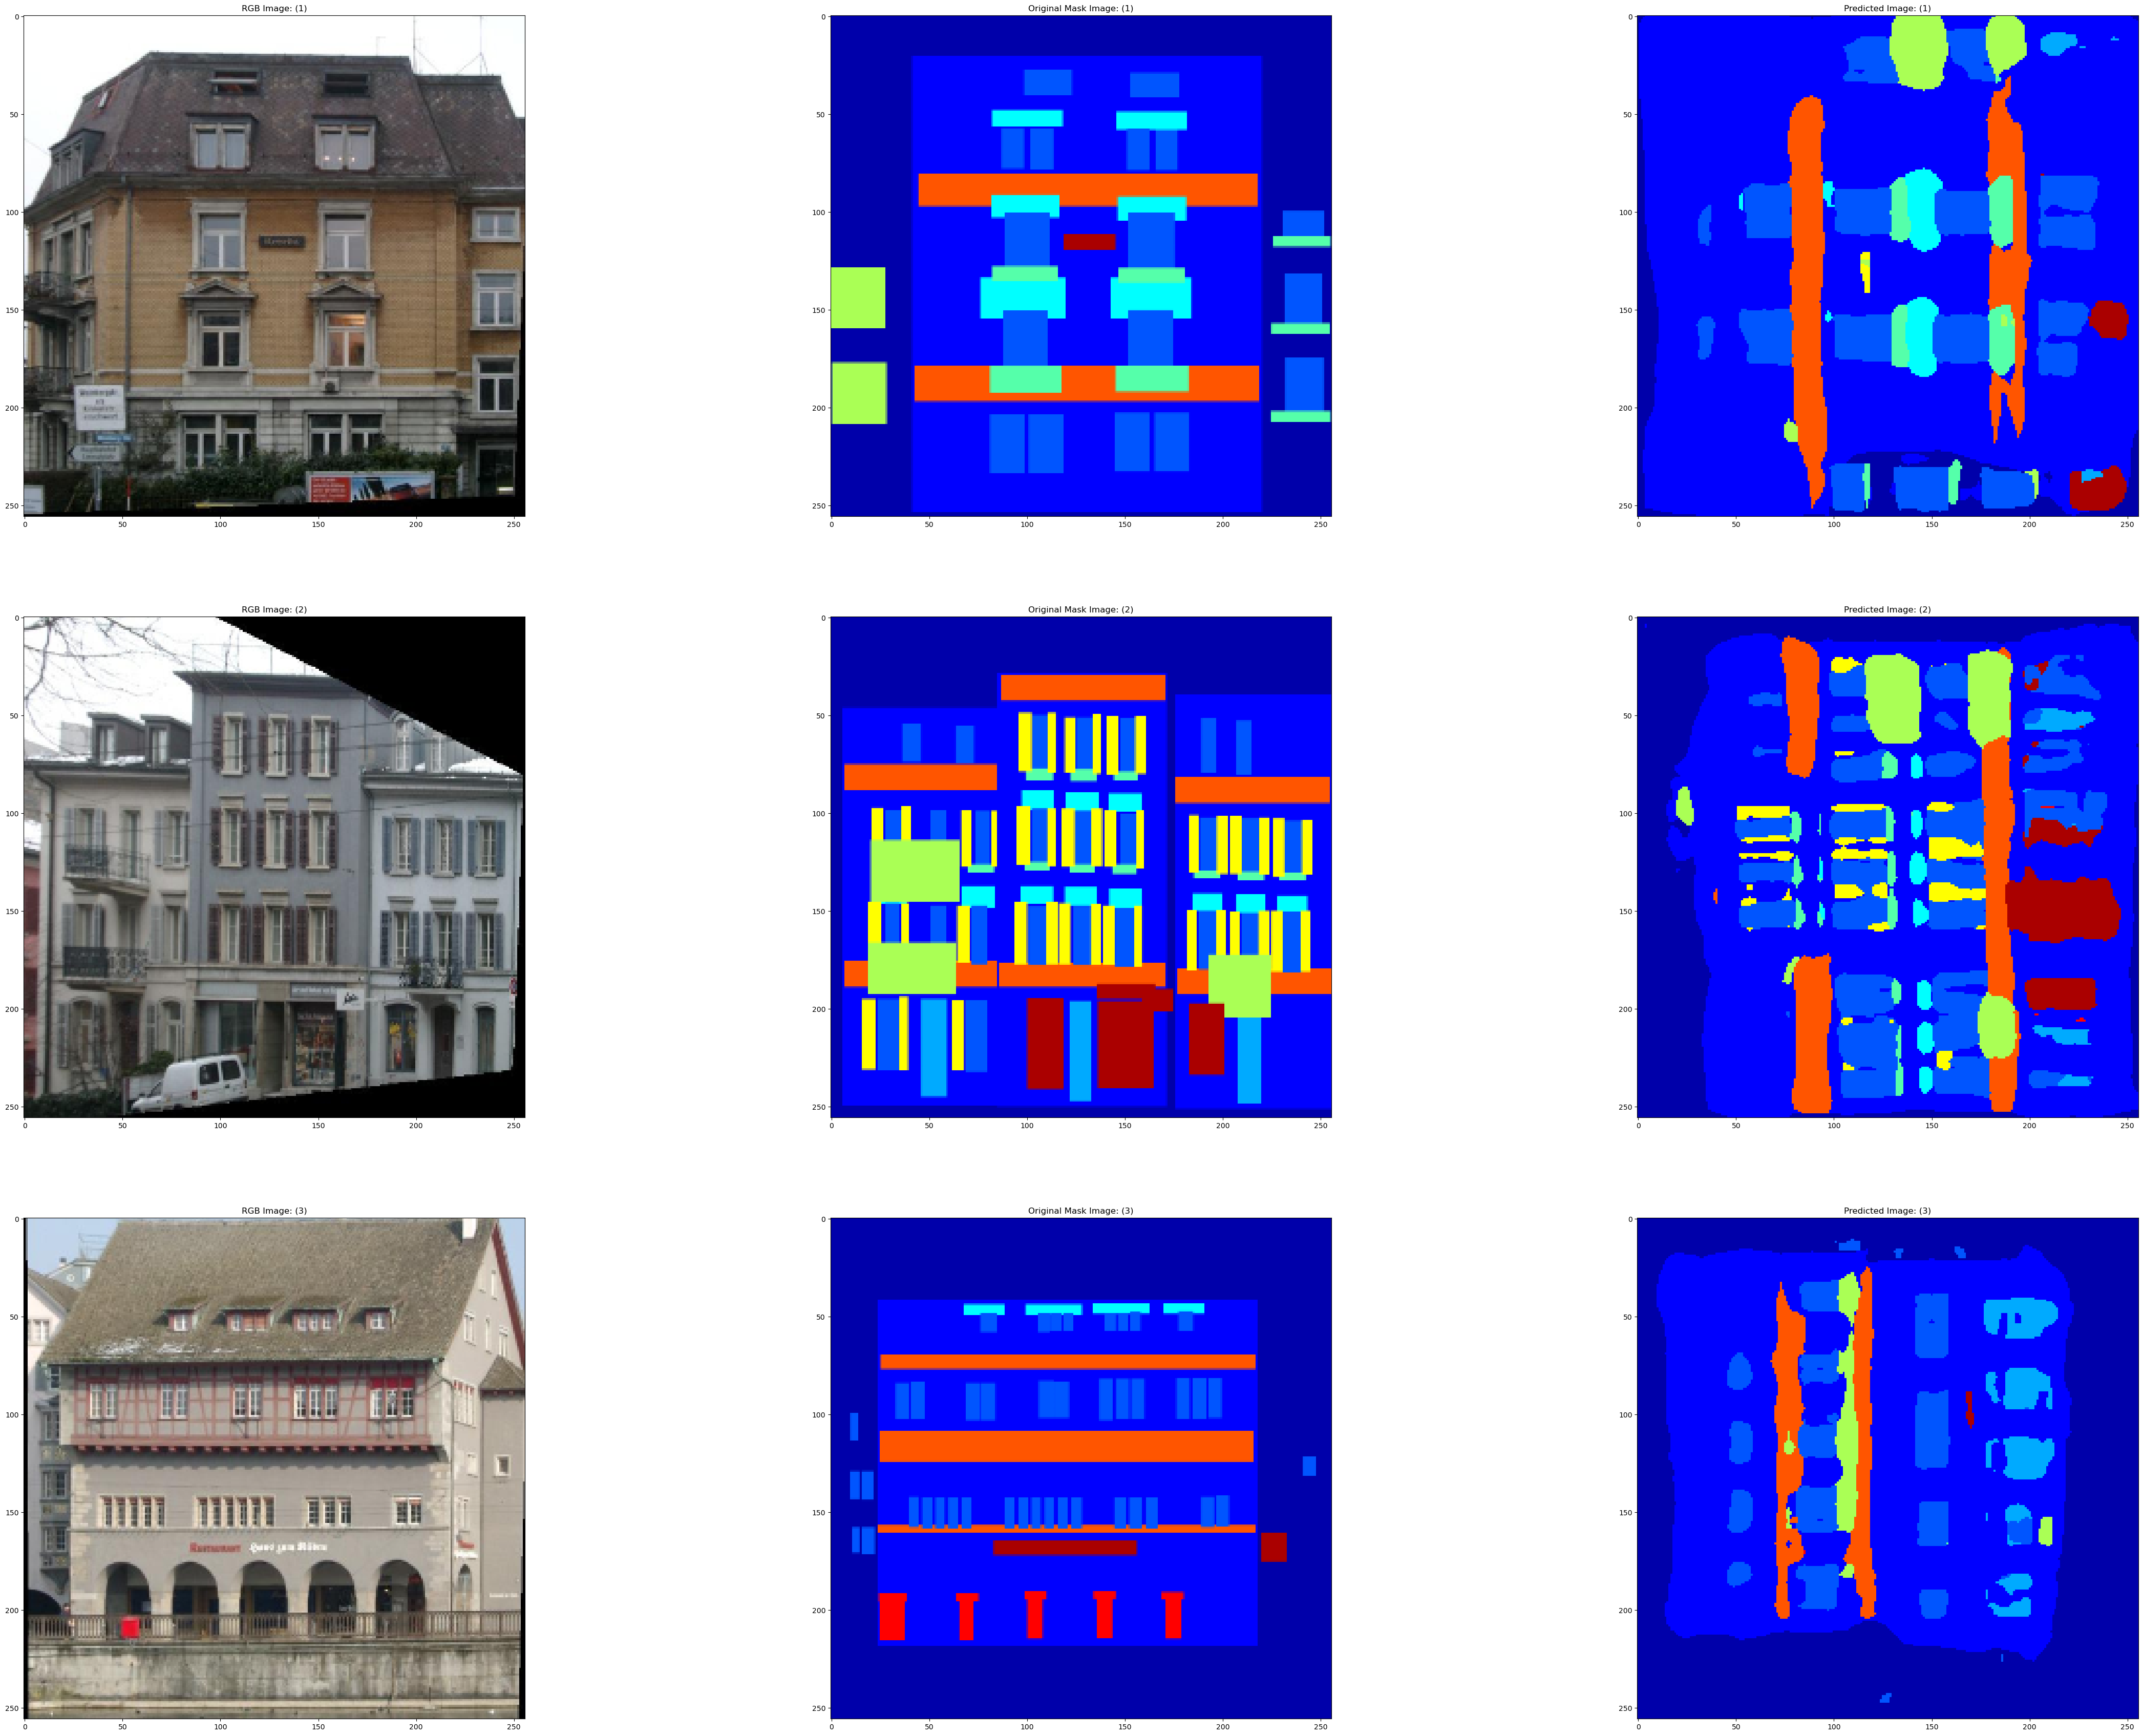

In [32]:
# Saving Final batch images
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols,cols, n + 1)
        if image.ndim == 2:
            plt.gray()
        print(image.shape)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.savefig("/kaggle/working/model.png", bbox_inches='tight')
    plt.show()
# Inserting Images into list
imagesList = []
batch = originalImageTest.shape[0] - 1
print(type(originalImage))
imgSave = originalImageTest.detach().cpu().numpy()
maskSave = originalMaskTest.detach().cpu().numpy()
#print("Before  Predicted permute: ",predictedLabelsSave.shape)
predictedLabels = torch.permute(predictedLabels, (0,3,2,1))
predictedLabelsSave = predictedLabels.detach().cpu().numpy()
namesOfImages = []
print("After Predicted permute: ",predictedLabelsSave.shape)
for i in range(0,batch):
    newImg = imgSave[i]
    h,w,c = newImg.shape[1], newImg.shape[0], newImg.shape[2]
    newImg = newImg.reshape(w,h,c)
    
    newMask = maskSave[i]
    h,w,c = newMask.shape[1], newMask.shape[0], newMask.shape[2]
    newMask = newMask.reshape(w,h,c)
    
    NewpredictedLabels = predictedLabelsSave[i]
    print("NEw Preedicted Labels: ",NewpredictedLabels.shape)
    h,w,c = NewpredictedLabels.shape[1], NewpredictedLabels.shape[0], NewpredictedLabels.shape[2]
    NewpredictedLabels = NewpredictedLabels.reshape(w,h,c)
    
    imagesList.append(newImg)
    namesOfImages.append(f"RGB Image: ({i+1})")
    imagesList.append(newMask)
    namesOfImages.append(f"Original Mask Image: ({i+1})")
    imagesList.append(NewpredictedLabels)
    namesOfImages.append(f"Predicted Image: ({i+1})")

show_images(imagesList, int(3),namesOfImages)

In [ ]:
# model(img_test.unsqueeze(0).cuda()).deatch().cpu().clone().numpy()
# which means that you are going to:
# deatch --> cut computational graph
# cpu --> allocate tensor in RAM
# clone --> clone the tensor not to modify the output in-place
# numpy --> port tensor to numpy